In [7]:
import jax
from jax import numpy as jnp
import numpy as np
import mediapy
import dataclasses
import chex

from scipy.interpolate import splprep, splev
from jax import vmap
import matplotlib.pyplot as plt
from waymax import datatypes
# jax.config.update("jax_enable_x64", True)

In [8]:
def calculate_distances_to_boundary(car_position, car_yaw, boundary_points, num_rays, max_distance=0.15):
    """
    calculate distances to boundary in different directions
    
    Args:
    car_position: car position (x, y)  shape (2,)
    car_yaw: car orientation in radians
    boundary_points: boundary points of the track    shape (N, 2)
    num_rays: number of rays to cast
    
    Returns:
    distances: distance to boundary in different directions    shape (num_rays,)
    hit_points: points of intersections of rays and boundary    shape (num_rays, 2)
    """

    angles = jnp.linspace(-jnp.pi/2, jnp.pi/2, num_rays)

    ray_directions = jnp.array([jnp.cos(car_yaw + angles), jnp.sin(car_yaw + angles)]) # (2, num_rays)

    relative_positions = boundary_points - car_position # (N, 2)
    projections = jnp.dot(relative_positions, ray_directions) # (N, num_rays)
    distances_to_points = jnp.linalg.norm(relative_positions, axis=1, keepdims=True)  # (N, 1)
    perpendicular_distances = jnp.sqrt(distances_to_points**2 - projections**2)  # (N, num_rays)
    
    valid_mask = (projections > 0) & (perpendicular_distances < max_distance)  
    valid_projections = jnp.where(valid_mask, projections, jnp.inf)  # (N, num_rays)

    distances = jnp.min(valid_projections, axis=0) # (num_rays,)
    hit_points = car_position + ray_directions.T * distances[:, None] # (num_rays, 2)
    
    return distances_to_points,projections,perpendicular_distances, distances, hit_points

In [9]:
def generate_racing_track(x, y, r, num_points=2000):
# Calculate tangent and normal vectors for each control point
    x_left = []
    y_left = []
    x_right = []
    y_right = []

    for i in range(len(x)):
        if i == 0:
            dx = x[i+1] - x[i]
            dy = y[i+1] - y[i]
        elif i == len(x) - 1:
            dx = x[i] - x[i-1]
            dy = y[i] - y[i-1]
        else:
            dx = x[i+1] - x[i-1]
            dy = y[i+1] - y[i-1]

        length = jnp.sqrt(dx**2 + dy**2)
        dx /= length
        dy /= length

        normal_x = -dy
        normal_y = dx

        width = r[i]  # Dynamic width based on r

        x_left.append(x[i] + normal_x * width / 2)
        y_left.append(y[i] + normal_y * width / 2)
        x_right.append(x[i] - normal_x * width / 2)
        y_right.append(y[i] - normal_y * width / 2)

    # Create new splines for left and right edges using the control points
    tck, _ = splprep([x, y], s=0, per=1)
    tck_left, _ = splprep([x_left, y_left], s=0, per=1)
    tck_right, _ = splprep([x_right, y_right], s=0, per=1)

    u_new = jnp.linspace(0, 1, num_points)
    x_center_smooth, y_center_smooth = splev(u_new, tck)
    x_left_smooth, y_left_smooth = splev(u_new, tck_left)
    x_right_smooth, y_right_smooth = splev(u_new, tck_right)

    return x_left_smooth, y_left_smooth, x_right_smooth, y_right_smooth, x_center_smooth, y_center_smooth

In [10]:
# new version of generate_racing_track
def generate_racing_track(x, y, r, num_points=2001, batch_size=None):
# Calculate tangent and normal vectors for each control point
    x_left = []
    y_left = []
    x_right = []
    y_right = []

    for i in range(len(x)):
        if i == 0:
            dx = x[i+1] - x[i]
            dy = y[i+1] - y[i]
        elif i == len(x) - 1:
            dx = x[i] - x[i-1]
            dy = y[i] - y[i-1]
        else:
            dx = x[i+1] - x[i-1]
            dy = y[i+1] - y[i-1]

        length = np.sqrt(dx**2 + dy**2)

        dx /= length
        dy /= length

        normal_x = -dy
        normal_y = dx

        width = r[i]  # Dynamic width based on r

        x_left.append(x[i] + normal_x * width / 2)
        y_left.append(y[i] + normal_y * width / 2)
        x_right.append(x[i] - normal_x * width / 2)
        y_right.append(y[i] - normal_y * width / 2)


    # Create new splines for left and right edges using the control points
    tck, _ = splprep([x, y], s=0, per=1)
    tck_left, _ = splprep([x_left, y_left], s=0, per=1)
    tck_right, _ = splprep([x_right, y_right], s=0, per=1)

    u_new = np.linspace(0, 1, num_points)
    x_center, y_center = splev(u_new, tck)
    x_left, y_left = splev(u_new, tck_left)
    x_right, y_right = splev(u_new, tck_right)

    # Remove the last point to avoid duplicate points
    x_center = x_center[:-1]
    y_center = y_center[:-1]
    x_left = x_left[:-1]
    y_left = y_left[:-1]
    x_right = x_right[:-1]
    y_right = y_right[:-1]


    dx_center = np.diff(x_center)
    dy_center = np.diff(y_center)

    segment_lengths = np.sqrt(dx_center**2 + dy_center**2)
    cumulative_length = np.cumsum(segment_lengths)
    cumulative_length = np.insert(cumulative_length, 0, 0)

    normalized_length = cumulative_length / cumulative_length[-1]

    dx_left = np.diff(x_left)
    dy_left = np.diff(y_left)
    dx_right = np.diff(x_right)
    dy_right = np.diff(y_right)
    
    # To keep the directions array the same length as the other arrays, append the last direction
    dx_center = np.append(dx_center, dx_center[-1])
    dy_center = np.append(dy_center, dy_center[-1])
    dx_left = np.append(dx_left, dx_left[-1])
    dy_left = np.append(dy_left, dy_left[-1])
    dx_right = np.append(dx_right, dx_right[-1])
    dy_right = np.append(dy_right, dy_right[-1])

    # normalize the directions
    dx_center /= np.sqrt(dx_center**2 + dy_center**2)
    dy_center /= np.sqrt(dx_center**2 + dy_center**2)
    dx_left /= np.sqrt(dx_left**2 + dy_left**2)
    dy_left /= np.sqrt(dx_left**2 + dy_left**2)
    dx_right /= np.sqrt(dx_right**2 + dy_right**2)
    dy_right /= np.sqrt(dx_right**2 + dy_right**2)

    x_points = np.concatenate([x_center, x_left, x_right])
    y_points = np.concatenate([y_center, y_left, y_right])
    dir_x = np.concatenate([dx_center, -dx_left, dx_right])   # different directions for left and right boundary ????
    dir_y = np.concatenate([dy_center, -dy_left, dy_right])
    point_types = np.ones(num_points-1, dtype=np.int32)
    point_types = np.concatenate([point_types, point_types*15, point_types*15]) # 1: centerline, 15: road boundary

    x_points = jnp.array(x_points, dtype=jnp.float32)
    y_points = jnp.array(y_points, dtype=jnp.float32)
    dir_x = jnp.array(dir_x, dtype=jnp.float32)
    dir_y = jnp.array(dir_y, dtype=jnp.float32)
    point_types = jnp.array(point_types, dtype=jnp.int32)
    if batch_size is None:
        roadgraph_points = datatypes.RoadgraphPoints(
            x=x_points, # shape (num_points-1,)
            y=y_points,
            z=jnp.zeros_like(x_points),
            dir_x=dir_x,
            dir_y=dir_y,
            dir_z=jnp.zeros_like(x_points),
            types=point_types,
            ids=jnp.ones_like(x_points, dtype=jnp.int32),   # different ids for left and right boundary ??
            valid=jnp.ones_like(x_points, dtype=jnp.bool_),
        )
    else:        
        x_points = jnp.expand_dims(x_points, axis=0).repeat(batch_size, axis=0) # shape (batch_size, num_points-1=1000)
        y_points = jnp.expand_dims(y_points, axis=0).repeat(batch_size, axis=0)
        dir_x = jnp.expand_dims(dir_x, axis=0).repeat(batch_size, axis=0)
        dir_y = jnp.expand_dims(dir_y, axis=0).repeat(batch_size, axis=0)
        point_types = jnp.expand_dims(point_types, axis=0).repeat(batch_size, axis=0)

        roadgraph_points = datatypes.RoadgraphPoints(
            x=x_points,   
            y=y_points,
            z=jnp.zeros_like(x_points),
            dir_x=dir_x,
            dir_y=dir_y,
            dir_z=jnp.zeros_like(x_points, dtype=jnp.float32),
            types=point_types,
            ids=jnp.ones_like(x_points, dtype=jnp.int32),   # different ids for left and right boundary ??
            valid=jnp.ones_like(x_points, dtype=jnp.bool_),
        )


    return roadgraph_points, jnp.array(x_center), jnp.array(y_center) ,cumulative_length

In [11]:
class TrackControlPoints:
    # Control points for the racing track, can be modified to create different tracks

    x = [30.3914, 34.5985, 37.9136, 41.6058, 44.124, 45.9188, 47.1959, 46.7351, 47.377, 47.6532, 46.6591, 
         46.5467, 47.6512, 50.0049, 52.5865, 53.9889, 54.3171, 54.2784, 53.4375, 52.333, 52.4365, 52.7472, 
         52.8369, 55.1218, 58.2352, 61.1966, 63.6817, 63.8858, 63.6888, 62.9846, 61.3693, 60.3086, 61.1369, 
         62.628, 63.8217, 63.6216, 63.6008, 60.7928, 57.7416, 55.1978, 52.4077, 50.7395, 48.7177, 46.7472, 
         44.5036, 42.2313, 40.4915, 39.5135, 38.3055, 36.587, 34.6551, 32.3964, 30.7208, 29.1654, 27.7528, 
         26.6793, 24.522, 22.221, 19.7474, 19.1721, 19.4022, 20.2766, 21.5824, 20.4607, 19.5942, 18.8348, 
         17.8684, 17.3219, 17.6429, 19.1694, 20.7179, 24.2734, 27.8213]
    y = [20.1282, 20.1528, 20.2138, 20.2842, 20.7843, 22.4755, 24.7191, 27.2454, 29.406, 31.7393, 34.3911, 
         36.9626, 39.0335, 39.6952, 39.4935, 37.7643, 35.5898, 33.2763, 30.4582, 27.3863, 25.0047, 22.5748, 
         20.3727, 19.9309, 19.6341, 19.5305, 20.4003, 23.1452, 25.8114, 27.7581, 29.2077, 32.5508, 35.243, 
         37.1483, 39.4283, 41.6718, 44.6677, 46.0382, 46.4869, 45.5216, 45.234, 45.2915, 46.1012, 46.1193, 
         45.9755, 45.6591, 44.8517, 43.0108, 41.8028, 40.0157, 38.8012, 39.2758, 40.0983, 41.2595, 43.9097, 
         45.7592, 46.6796, 46.7659, 46.1906, 43.9183, 42.0775, 39.5521, 37.8896, 35.5483, 33.2801, 30.8985, 
         28.4824, 25.8132, 22.2225, 20.5131, 19.6407, 19.9199, 20.0432]
    r = [4.6, 4.6, 4.6, 4.6, 4.0, 3.0, 3.0, 3.0, 3.0, 1.6, 2.4, 4.6, 5.6, 4.98, 5.4, 5.4, 3.0, 2.4, 2.2, 
         2.4, 2.4, 4.4, 4.4, 4.0, 3.0, 3.0, 4.4, 4.0, 3.4, 3.8, 3.4, 2.0, 3.6, 5.0, 4.0, 4.0, 6.0, 4.8, 4.0,
         2.0, 1.6, 2.0, 3.6, 4.4, 5.0, 6.0, 6.0, 5.0, 3.6, 3.4, 4.0, 3.0, 2.6, 3.0, 3.0, 3.0, 3.6, 3.6, 5.0, 
         4.8, 2.0, 1.6, 3.8, 2.8, 2.0, 1.8, 2.8, 3.0, 3.0, 4.6, 4.4, 4.4, 4.6]

In [12]:
# x_left, y_left, x_right, y_right, x_center, y_center = generate_racing_track(TrackControlPoints.x, TrackControlPoints.y, TrackControlPoints.r, num_points=1000)
# x_points = x_left.tolist()
# x_points.extend(x_right)
# y_points = y_left.tolist()
# y_points.extend(y_right)
# edge_points = list(zip(x_points, y_points))
# edge_points = jnp.array(edge_points)

In [13]:
# for new version of generate_racing_track
roadgraph_points, x_center, y_center, cumulative_length = generate_racing_track(TrackControlPoints.x, TrackControlPoints.y, TrackControlPoints.r)
edge_points = roadgraph_points.xy[..., 2000:,:]

In [32]:
print(edge_points.shape)

(4000, 2)


In [14]:
#[30.626804   20.0801     -0.10766554]
# car_pos = jnp.array([TrackControlPoints.x[0], TrackControlPoints.y[0]])+jnp.array([1, 2])
car_pos = jnp.array([30.626804 , 20.0801])
car_orientation = -0.10766554 #jnp.pi/4 # radians
num_rays = 8  # Number of rays to cast
max_distance = 0.1 # Maximum perpendicular distance to consider for filtering points

5.7769265
15.275678
0.0
0.0
[ 2.2626715  2.395833   3.1587074  6.446669  16.895414   4.2604556
  2.7151055  2.3381612]


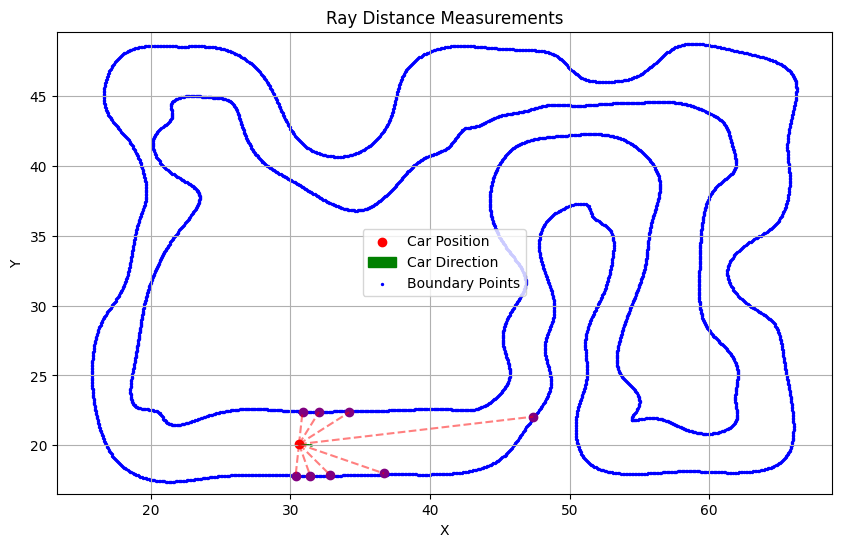

In [15]:
distances_to_points,projections, perpendicular_distances,distances, hit_points = calculate_distances_to_boundary(car_pos, car_orientation, edge_points, num_rays, max_distance)
print(projections.mean())
print(perpendicular_distances.mean())
distances_to_points = jnp.tile(distances_to_points, (1, num_rays))
print(jnp.min(distances_to_points - projections))
print(jnp.sqrt(jnp.min(distances_to_points**2 - projections**2)))
print(distances)
plt.figure(figsize=(10, 6))

# plot car position and orientation
plt.scatter(*car_pos, color='red', label='Car Position')
car_direction = jnp.array([jnp.cos(car_orientation), jnp.sin(car_orientation)]) 
plt.arrow(car_pos[0], car_pos[1], car_direction[0], car_direction[1], 
          color='green', head_width=0.1, length_includes_head=True, label='Car Direction')

# plot track boundary points
plt.scatter(edge_points[:, 0], edge_points[:, 1], color='blue', label='Boundary Points', s=2)

# plot hit points and rays
for i in range(num_rays):
    plt.plot([car_pos[0], hit_points[i, 0]], [car_pos[1], hit_points[i, 1]], 
             'r--', alpha=0.5)
    plt.scatter(hit_points[i, 0], hit_points[i, 1], color='purple')

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ray Distance Measurements')
plt.grid(True)
plt.axis('equal')
plt.show()